# Imports

In [1]:
from __future__ import annotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

%matplotlib inline
pd.options.display.max_columns = None
plt.style.use("ggplot")

In [2]:
df = pd.read_csv('wine-quality.csv')

# Data Preparation

## Check for duplicate rows

In [3]:
df.shape

(6497, 13)

In [4]:
df.duplicated().sum()

1177

In [5]:
df = df.drop_duplicates()
df.shape

(5320, 13)

## Change spaces in column names to underscores

In [6]:
df.columns = df.columns.str.replace(' ', '_')


## Check for missing values

In [7]:
df.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Exploratory Data Analysis

## Basic information about the dataset

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5320 non-null   object 
 1   fixed_acidity         5320 non-null   float64
 2   volatile_acidity      5320 non-null   float64
 3   citric_acid           5320 non-null   float64
 4   residual_sugar        5320 non-null   float64
 5   chlorides             5320 non-null   float64
 6   free_sulfur_dioxide   5320 non-null   float64
 7   total_sulfur_dioxide  5320 non-null   float64
 8   density               5320 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5320 non-null   float64
 11  alcohol               5320 non-null   float64
 12  quality               5320 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB


In [9]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [10]:
df.describe(include="object")

,type
count,5320
unique,2
top,white
freq,3961


<hr />

## Distribution of each feature

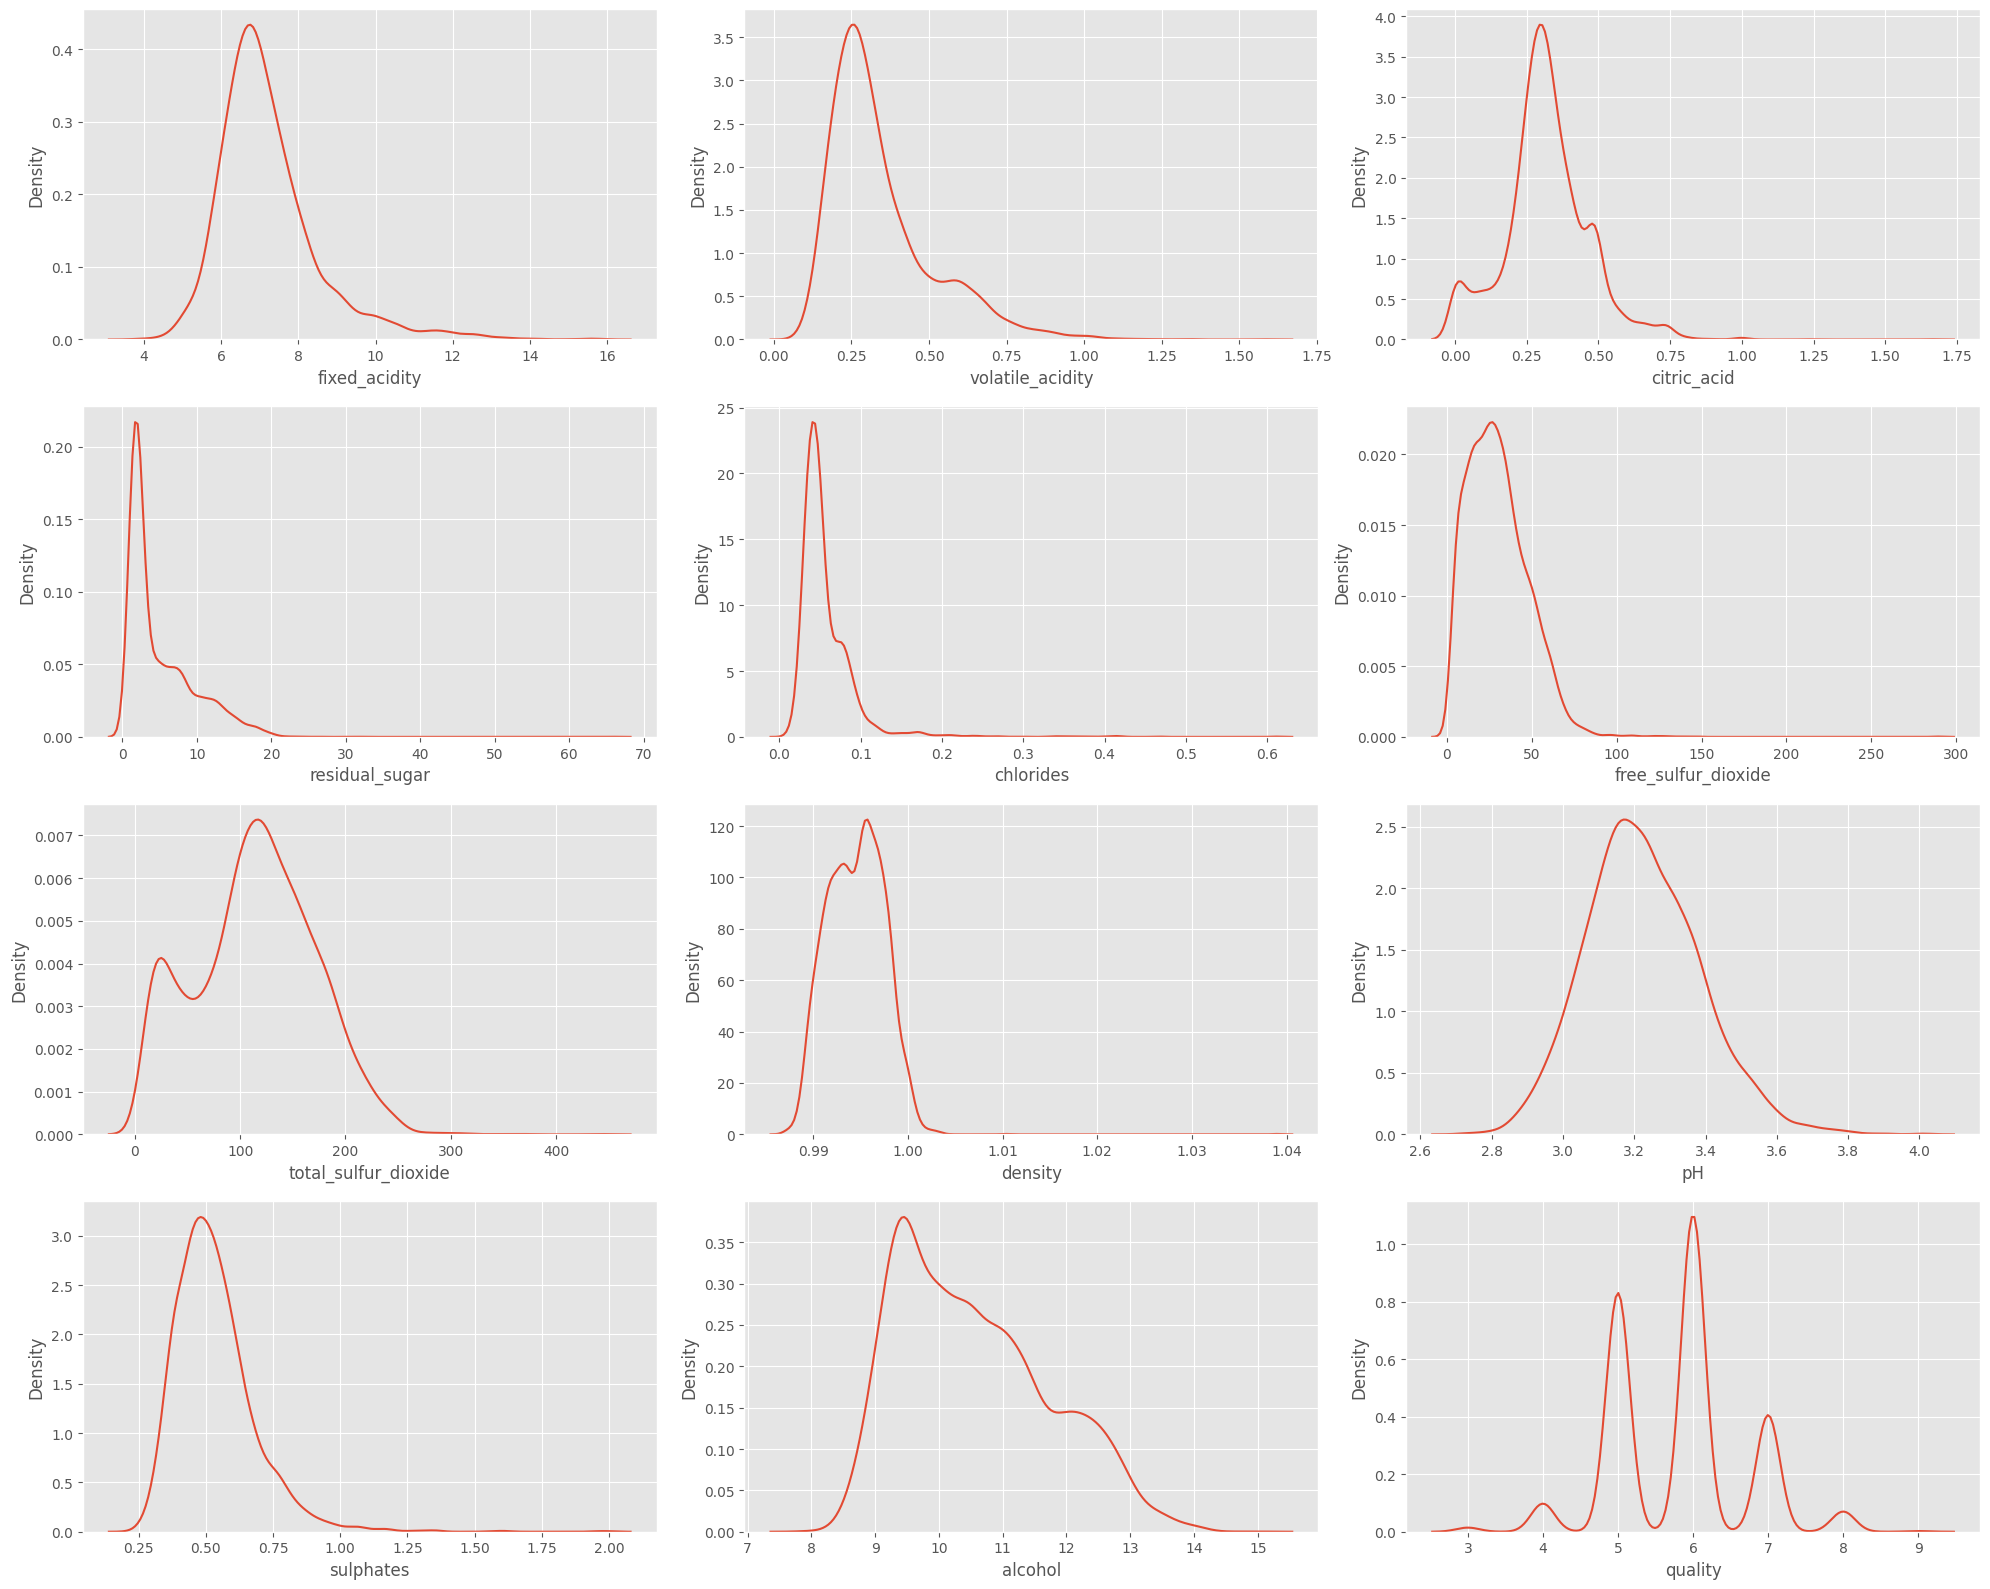

In [11]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.kdeplot(df.select_dtypes(exclude="object").iloc[:, i], ax=ax)

These histograms tell me that the distribution of the data for all of the skewed to the left. This means that I will need to do some data transformation on the fields I decide to keep, so that the data is more normally distributed.

<hr />

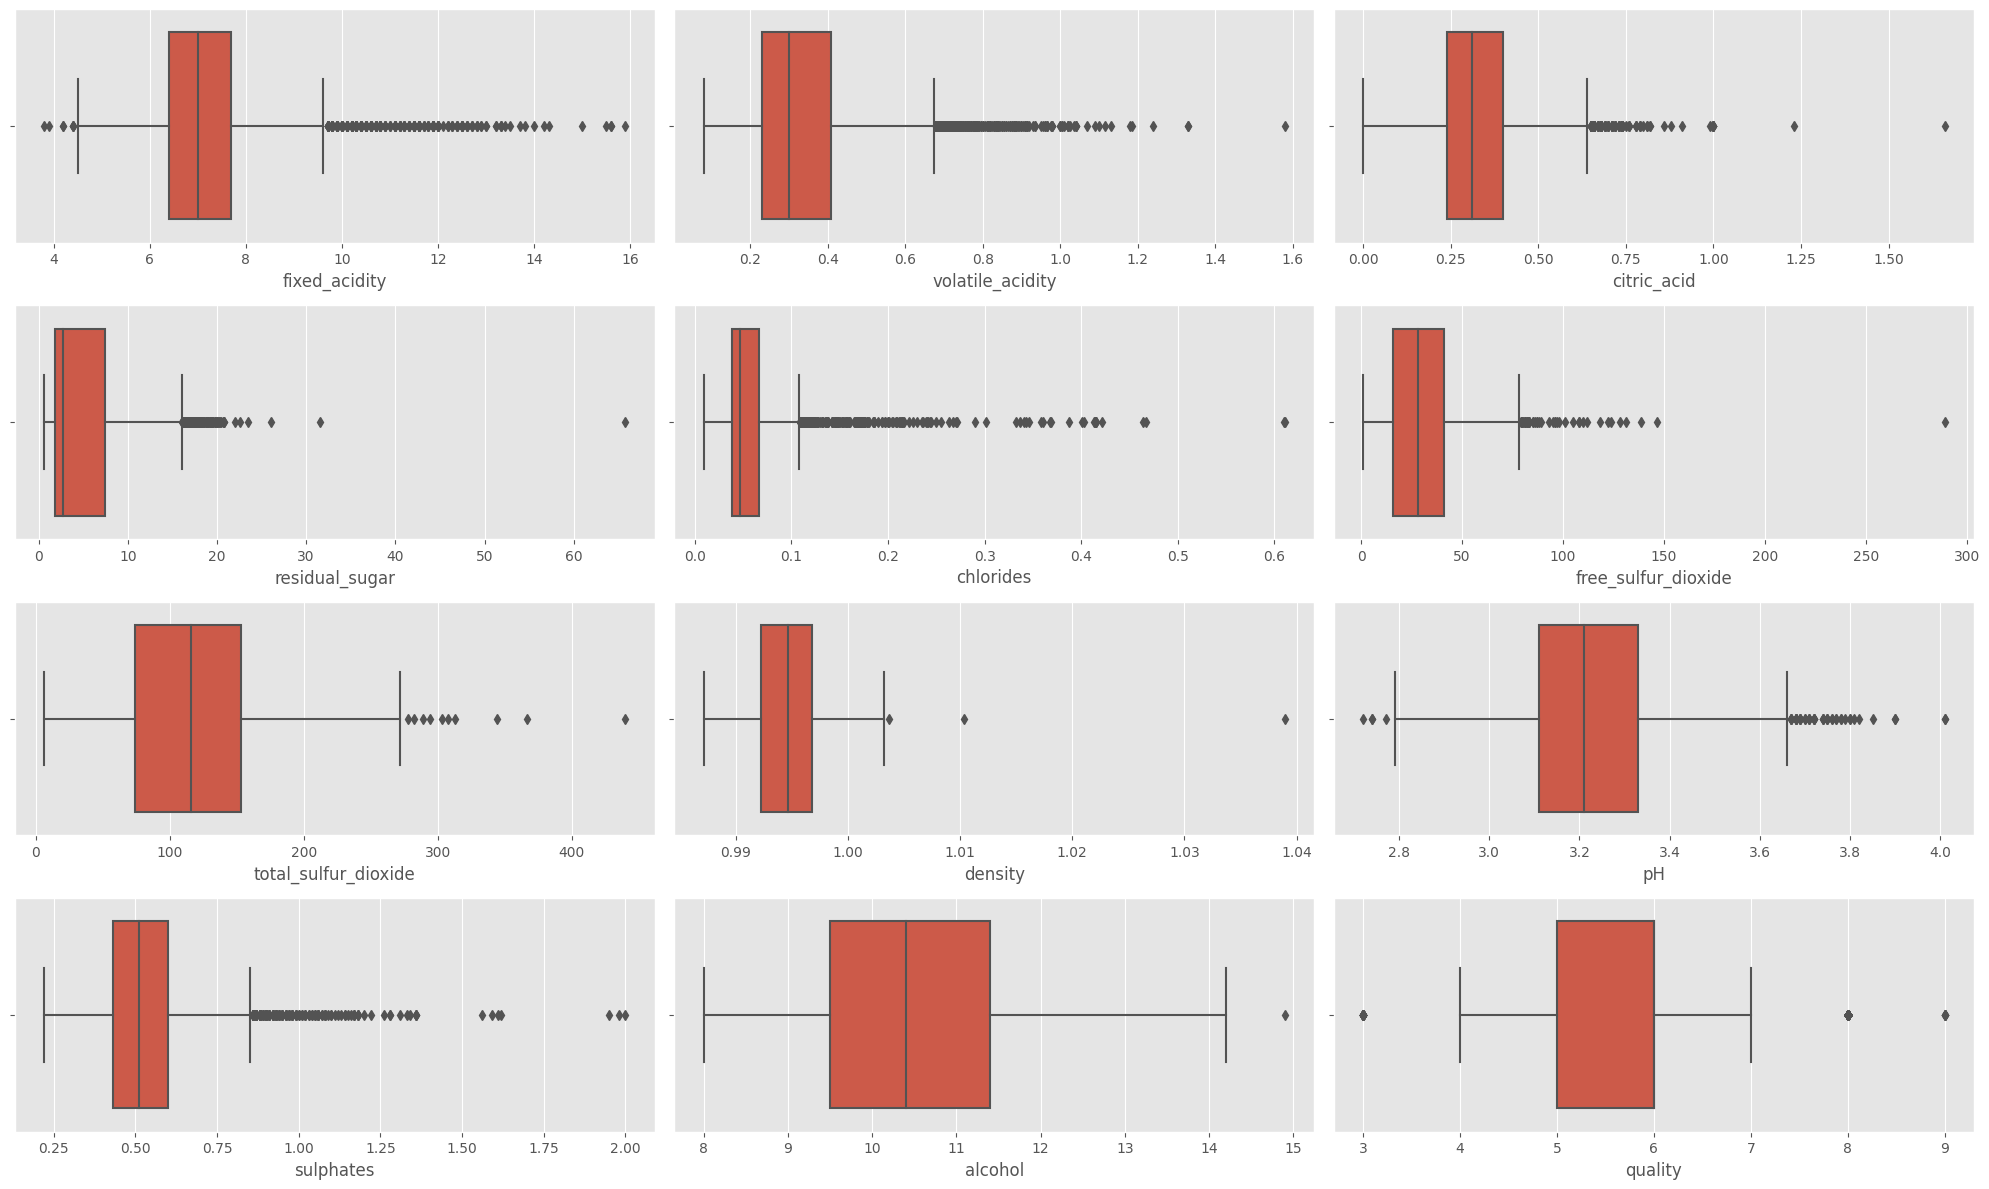

In [12]:
fig, axes = plt.subplots(4, 3, figsize=(20, 12), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.boxplot(x=df[df.select_dtypes(exclude="object").columns.array[i]], ax=ax)

These boxplots tell me that there are some outliers in the data. I will need to decide if I want to keep these outliers or not.

<hr />

## Handling Outliers

For each of the fields, I decided to do some trail and error to find out what percentile of the data (top and bottom percentile) I want to replace with the median value of the column, keeping the percentile value change to a minimum so as to not impute too many fields, but also to remove as many outliers as possible. Here are the outcomes of my trail and erroring

In [ ]:
trim_config: dict[str, tuple[int, int]] = {
    "fixed_acidity": (0.03, 0.92),
    "volatile_acidity": (0, 0.81),
    "citric_acid": (0.06, 0.95),
    "residual_sugar": (0, 0.93),
    "chlorides": (0, 0.92),
    "free_sulfur_dioxide": (0, 0.9),
    "total_sulfur_dioxide": (0, 0.95),
    "density": (0, 0.99),
    "pH": (0.01, 0.98),
    "sulphates": (0, 0.96),
    "alcohol": (0, 0.99),
    "quality": (0.01, 0.97)
}

for feature, iqr_range in trim_config.items():
    df[f"{feature}_trimmed"] = df[feature].clip(
        df[feature].quantile(iqr_range[0]),
        df[feature].quantile(iqr_range[1])
    )

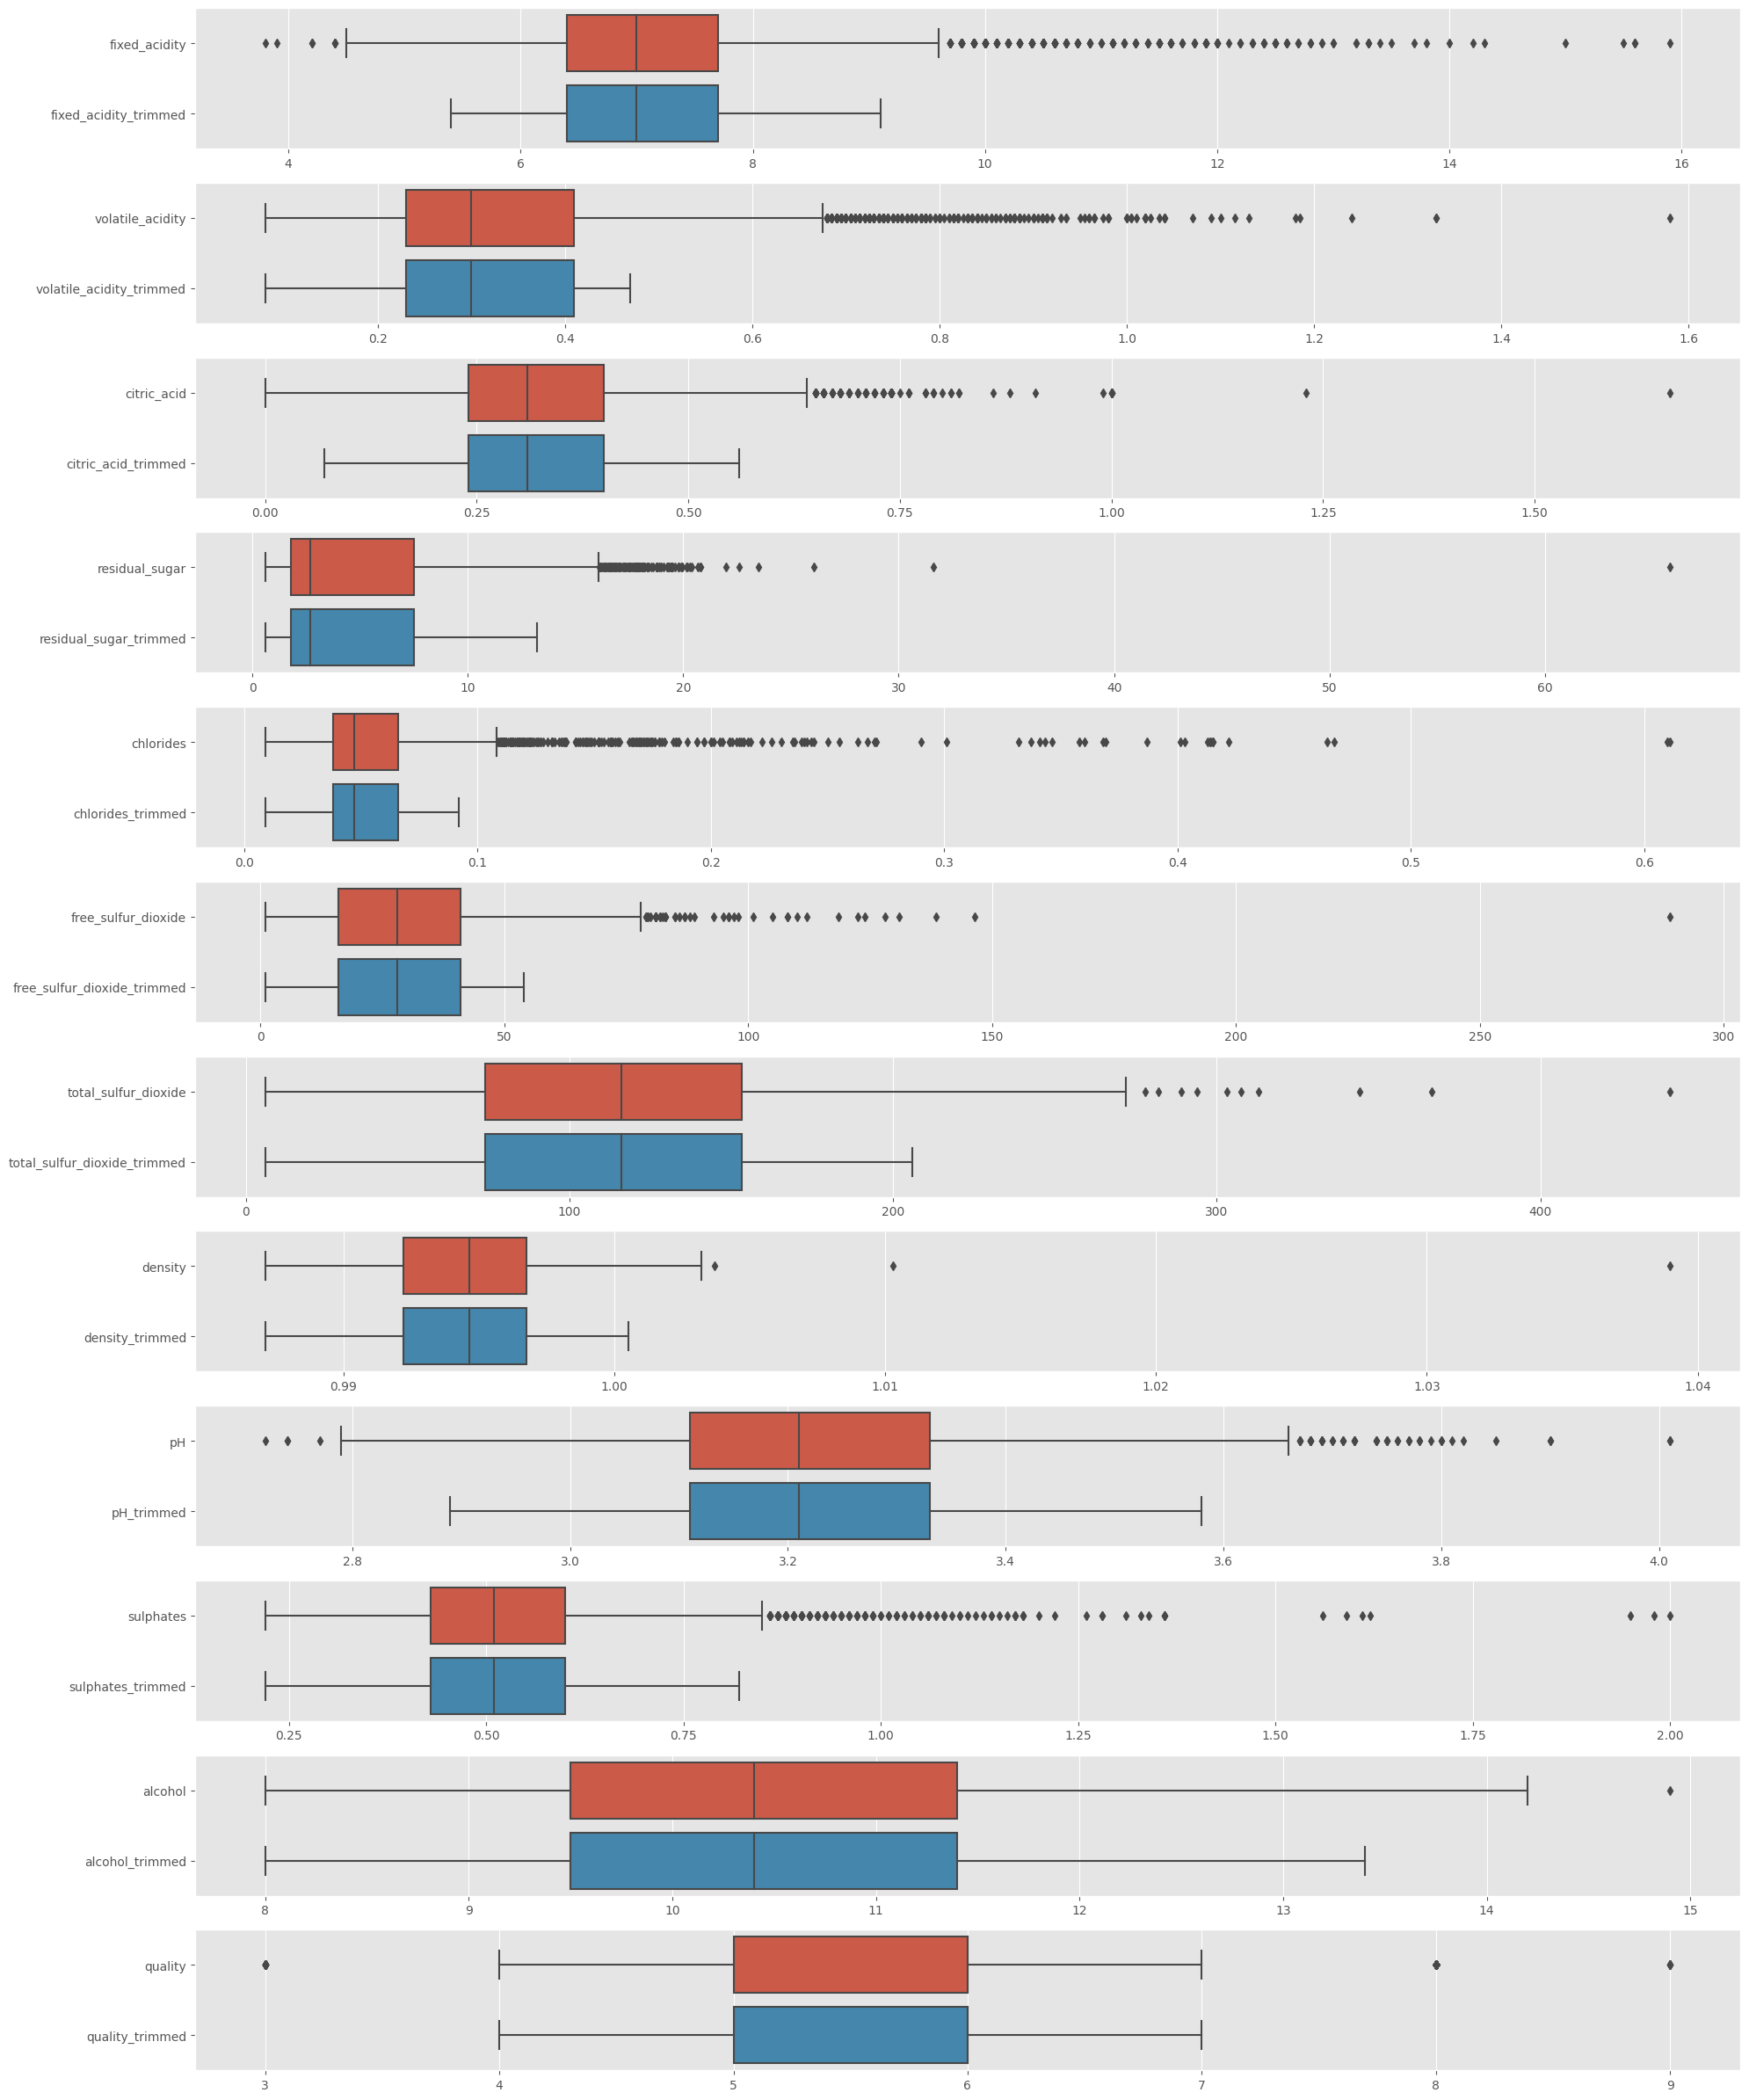

In [537]:
fig, axes = plt.subplots(12, 1, figsize=(20, 24), tight_layout=True)

for i, ax in enumerate(axes.flat):
    feature = df.select_dtypes(exclude="object").columns.array[i]
    sns.boxplot(
        pd.melt(df[[feature, f"{feature}_trimmed"]]),
        x="value",
        y="variable",
        ax=ax
    ).set(
        xlabel=None,
        ylabel=None
    )

### Overwriting the original columns with the trimmed columns

In [27]:
for feature in df.select_dtypes(exclude="object").columns:
    if "_trimmed" not in feature:
        df[feature] = df[f"{feature}_trimmed"]
        df = df.drop(columns=f"{feature}_trimmed")

## Correlation of each feature

<AxesSubplot: >

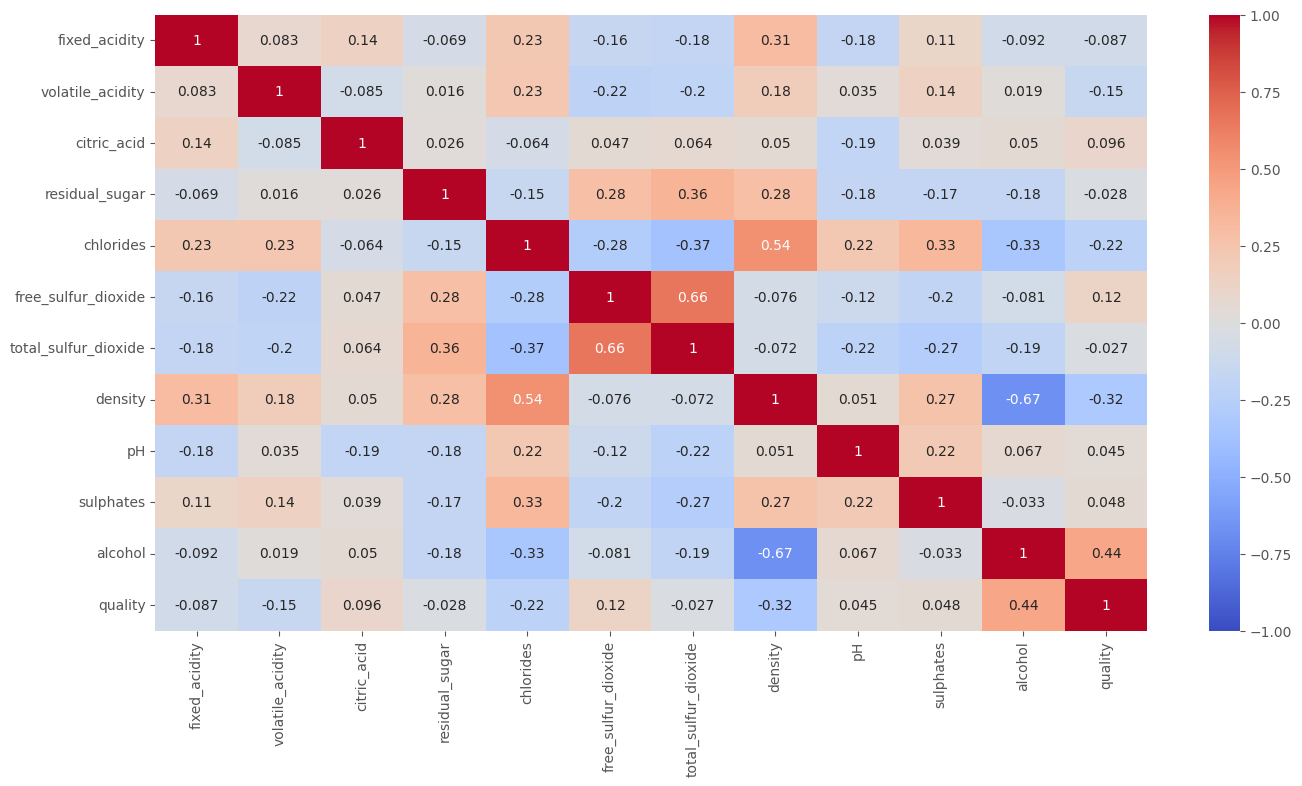

In [28]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(
    df.corr(numeric_only=True),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax,
)

This correlation heatmap tells me that the features have a moderate correlation with each other. This means that I will need to do some feature selection to reduce the number of features I use in my model.

<hr />

## Correlation of each feature with the target

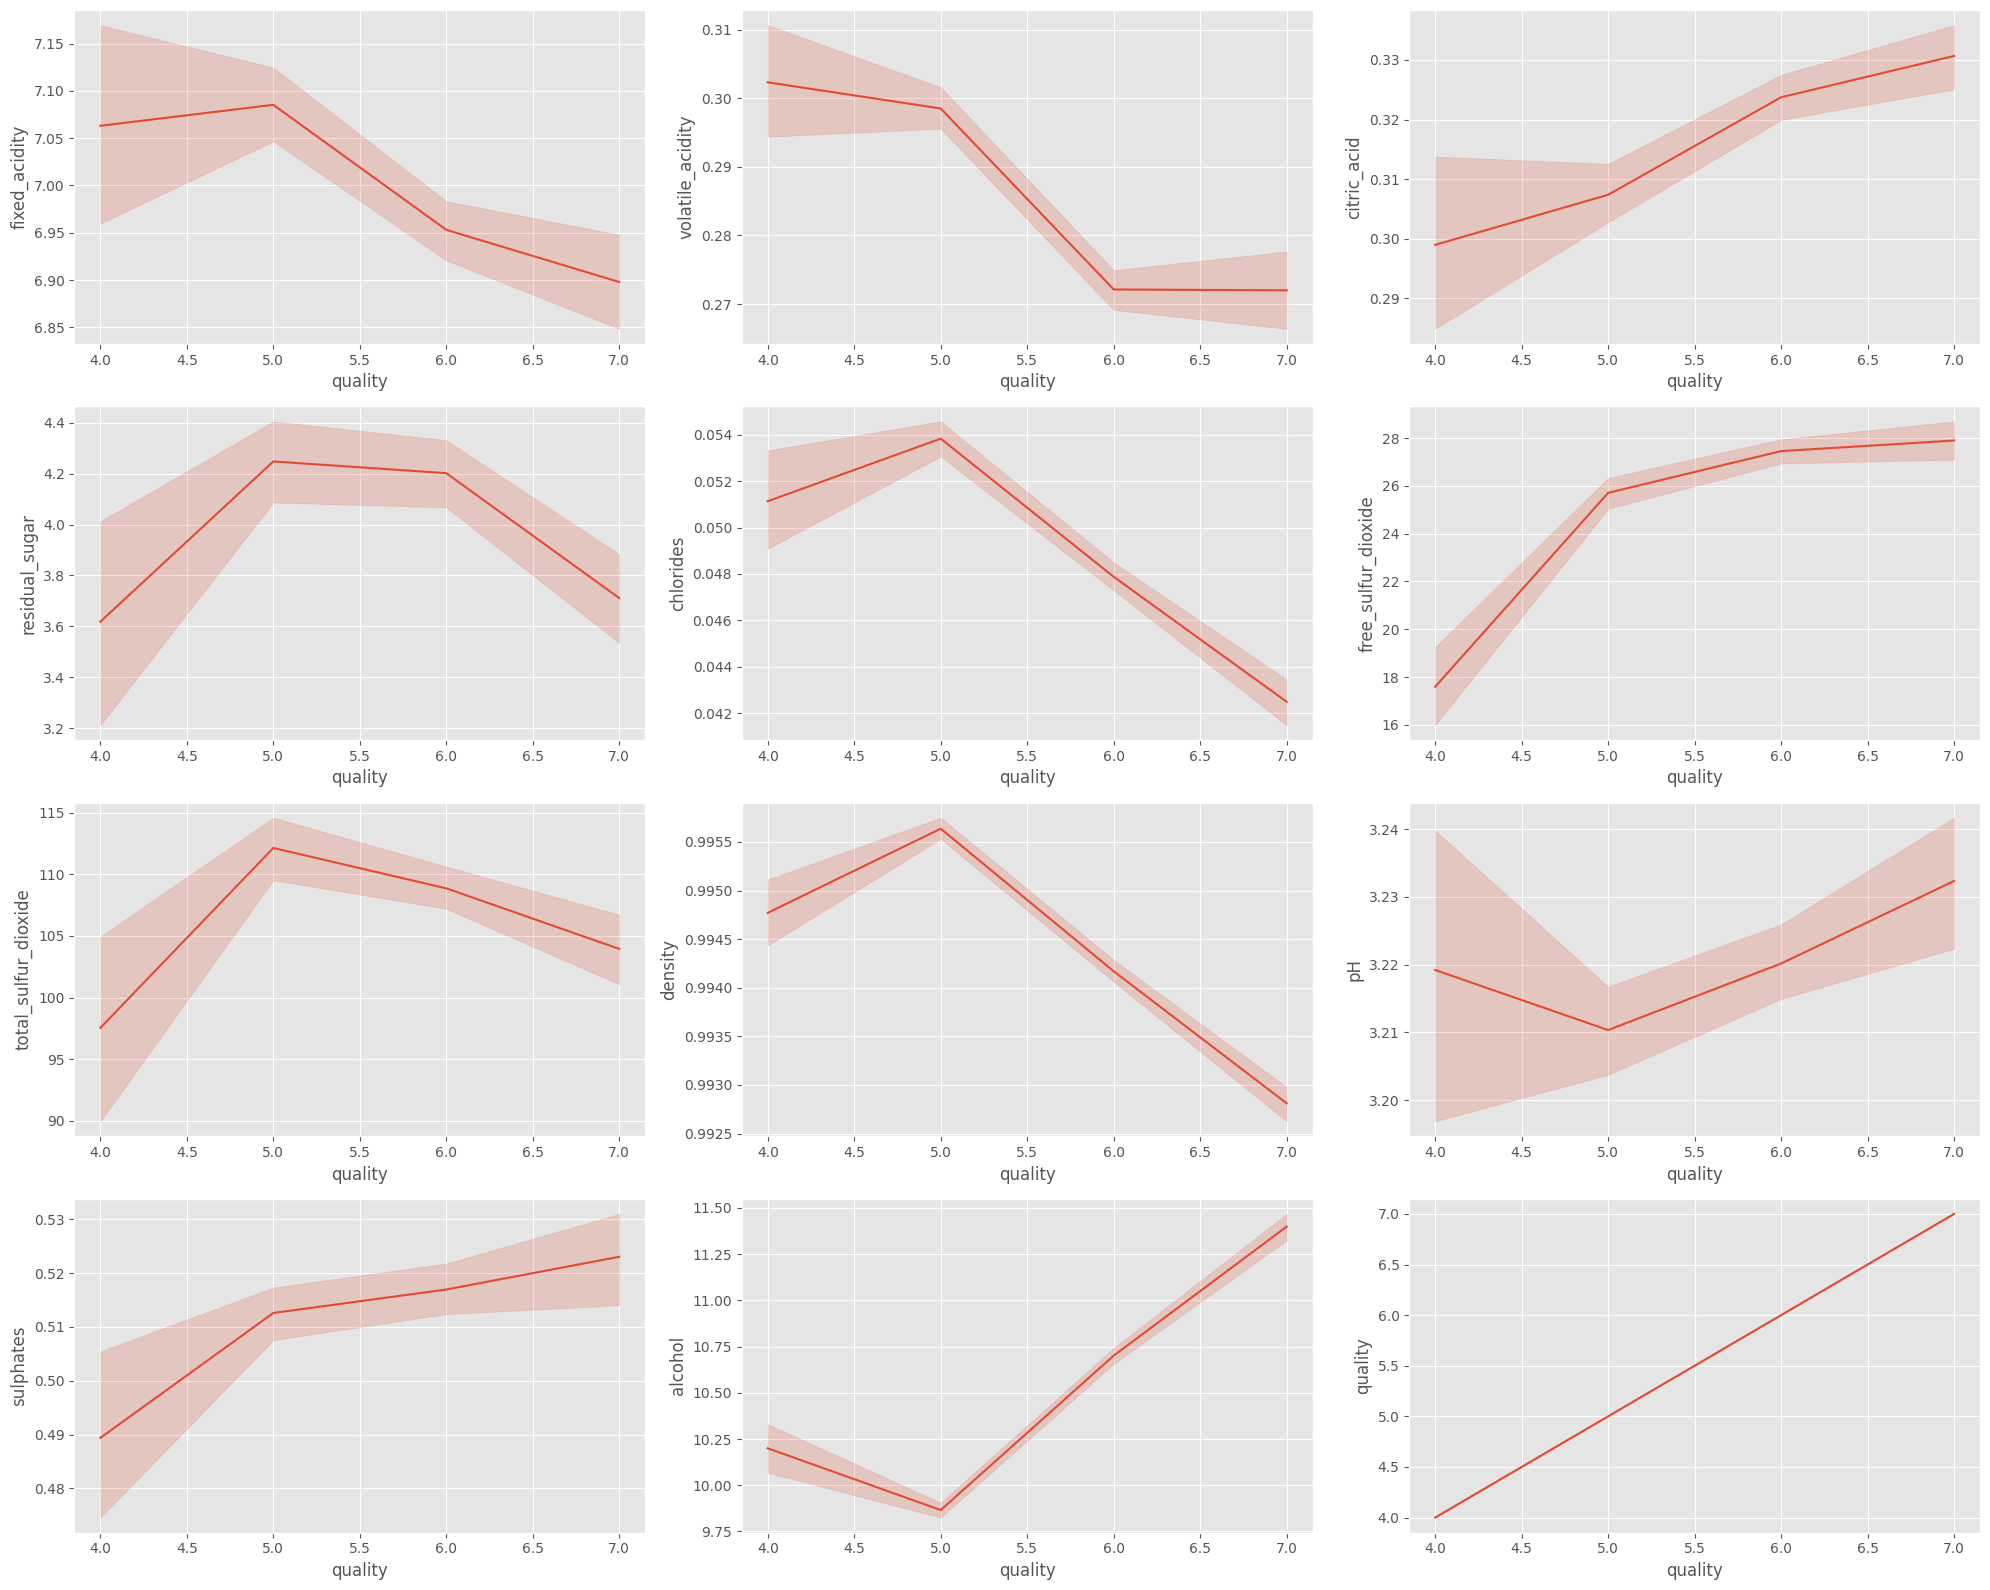

In [29]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.lineplot(df, x="quality", y=df.select_dtypes(exclude="object").columns.array[i], ax=ax)

These graphs tell me that some of the features are more likely to affect the quality of the wine than others since the lines are more linear than the others, and can be used to predict the quality of the wine better. 

<hr />

# Feature Engineering

## Feature Selection

## Making the Features Normally Distributed

In [ ]:
# feature = "volatile acidity"

# df[f"{feature}_trimmed"] = np.log(df[feature])
# fig, axes = plt.subplots(2, 3, figsize=(20, 12), tight_layout=True)
# sns.histplot(df[feature], ax=axes[0, 0])
# sns.histplot(df[f"{feature}_trimmed"], ax=axes[1, 0])
# sns.boxplot(x=df[feature], ax=axes[0, 1])
# sns.boxplot(x=df[f"{feature}_trimmed"], ax=axes[1, 1])
# sns.kdeplot(x=df[feature], ax=axes[0, 2])
# sns.kdeplot(x=df[f"{feature}_trimmed"], ax=axes[1, 2])

## Scaling Important Features

# Model Building

In [ ]:
df = pd.get_dummies(df, columns=["type"])

df.head()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("quality", axis=1), df["quality"], train_size=0.7, random_state=42)

In [ ]:
rfc = RandomForestRegressor(n_estimators=100, random_state=42)

rfc.fit(X_train, y_train)

rfc.score(X_test, y_test)